In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns
sns.set()

SINDy is a data-driven method used in the field of dynamical systems and nonlinear modeling. Its purpose is to identify the underlying dynamics of a system directly from observational data, without requiring detailed knowledge of the system's governing equations. Can be useful in cases where it is challenging or even impossible to derive the giverning equations analytically.

## SINDy Class

In [80]:
class Sindy:
  def __init__(self,dataset,time_vec,poly_order,model_order,use_sine,use_const):
    self.X = dataset
    self.time_vec = time_vec
    self.poly_order = poly_order
    self.use_sine = use_sine
    self.use_const = use_const
    self.model_order = model_order
    self.threshold = 10**(-1)
    self.grads = self.data_grad(model_order)

  def data_grad(self,order=1):
    dX = np.zeros(self.X.shape)
    n = len(self.X)
    dX[0] = (self.X[1] - self.X[0])/(self.time_vec[1] - self.time_vec[0])
    dX[n-1] = (self.X[n-1] - self.X[n-2])/(self.time_vec[n-1] - self.time_vec[n-2])
    for i in range(1,n-1):
      t2,t1 = self.time_vec[i+1],self.time_vec[i-1]
      dX[i] = (self.X[i+1] - self.X[i-1])/(t2 - t1)
    if order == 2:
      ddX = np.zeros(dX.shape)
      ddX[0] = (dX[1] - dX[0])/(self.time_vec[1] - self.time_vec[0])
      ddX[n-1] =(dX[n-1] - dX[n-2])/(self.time_vec[n-1] - self.time_vec[n-2])
      for i in range(1,n-2):
        ddX[i] = (self.X[i+1] - 2*self.X[i] + self.X[i-1])/((self.time_vec[i+1] - self.time_vec[i])**2)
      return {1:dX,2:ddX}
    return {1:dX}

  def get_library_size(self,n):
    l=0
    for k in range(self.poly_order+1):
      l += int(binom(n+k-1,k))
    if self.use_sine == True:
      l +=n
    if self.use_const == True:
      l +=1
    return l

  def library(self,data):
    m,n = data.shape
    l = self.get_library_size(n)
    lib = np.ones((m,l))
    idx = 1
    for i in range(n):
      lib[:,idx] = data[:,i]
      idx +=1

    if self.poly_order > 1:
      for i in range(n):
        for j in range(i,n):
          lib[:,idx] = data[:,i]*data[:,j]
          idx += 1

    if self.poly_order > 2:
      for i in range(n):
        for j in range(i,n):
          for k in range(j,n):
            lib[:,idx] = data[:,i]*data[:,j]*data[:,k]
            idx += 1

    if self.poly_order >3:
        for i in range(n):
            for j in range(i,n):
                for k in range(j,n):
                    for q in range(k,n):
                        lib[:,idx] = data[:,i]*data[:,j]*data[:,k]*data[:,q]
                        idx += 1

    if self.poly_order > 4:
        for i in range(n):
            for j in range(i,n):
                for k in range(j,n):
                    for q in range(k,n):
                        for r in range(q,n):
                            lib[:,idx] = data[:,i]*data[:,j]*data[:,k]*data[:,q]*data[:,r]
                            idx += 1

    if self.use_sine == True:
      for i in range(n):
        lib[:,idx] = np.sin(data[:,i])
        idx +=1


    return lib[:,1:]

  def library_high_order(self):
    res = (self.X,)
    for i in range(1,self.model_order):
      grad = self.grads[i]
      res = res + (grad,)
    res = np.concatenate(res,axis = 1)
    lib = self.library(res)
    return lib

  def fit(self,xdot, theta):
    m,n = xdot.shape
    ksi = np.linalg.lstsq(theta,xdot, rcond = None)[0]
    for i in range(10):
      small_coeffs = (abs(ksi) < self.threshold)
      ksi[small_coeffs] = 0
      big_coeffs = ~small_coeffs
      to_keep_args = ~np.all(small_coeffs, axis=1)
      sub_matrix = theta[:, to_keep_args]
      ksi[to_keep_args, :] = np.linalg.lstsq(sub_matrix,xdot, rcond = None)[0]
    ksi[abs(ksi) < self.threshold] = 0
    return ksi

# Test

We focus in this example to fit the following dynamics:


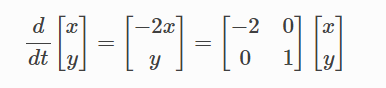

The solution to the this system of differential equation gives us:

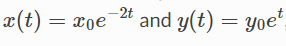

In [5]:
#Data
t = np.linspace(0,1,100)
x = 3*np.exp(-2*t)
y = 0.5* np.exp(t)
X = np.stack((x,y),axis = 1)

In [6]:
model_order = 1
poly_order = 1
sind_obj = Sindy(X,t,poly_order,model_order,False,False)
gradients = sind_obj.grads
dX = gradients[1]
lib = sind_obj.library(X)
ksi = sind_obj.fit(dX,lib)

In [7]:
def grad(t):
  n = t.shape[0]
  grad_x = -6*np.exp(-2*t).reshape((t.shape[0],1))
  grad_y = 0.5*np.exp(t).reshape((t.shape[0],1))
  return np.concatenate((grad_x,grad_y),axis=1)

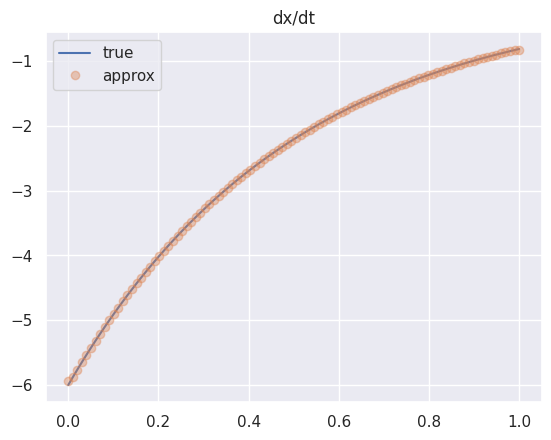

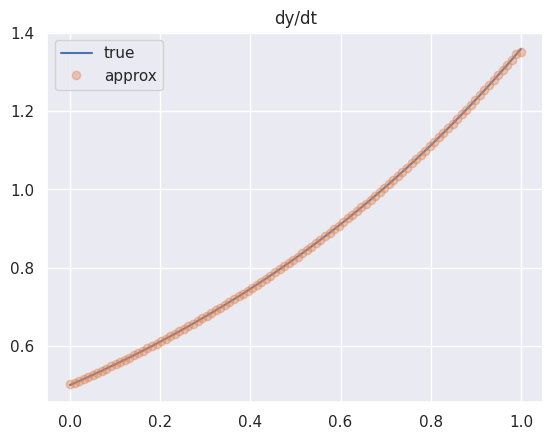

In [8]:
true_grad = grad(t)
titles = ["dx/dt","dy/dt"]
names = ["gradx","grady"]
approx_grad = dX
for i in range(true_grad.shape[1]):
  plt.figure()
  plt.title(titles[i])
  plt.plot(t,true_grad[:,i],label = "true")
  plt.plot(t,approx_grad[:,i],"o",alpha = 0.4,label = "approx")
  plt.legend()
  plt.savefig(names[i]+".jpg")

In [9]:
#Solving the ode discovered by SINDy
def simulate1(x0,t,ksi,lib_func,integrator):
  m = t.size
  n = x0.shape[0]
  l = ksi.shape[1]
  f = lambda t,x: np.dot(lib_func(np.array(x).reshape((1,n))),ksi).reshape((n,))
  if integrator == "odeint":
    x = odeint(f,x0,t,tfirst = True)
  else:
    x = solve_ivp(f, [t[0], t[-1]], x0, t_eval=t).y.T
  return x

In [10]:
x0 = 6
y0 = 0.1
init_condition = np.array([x0,y0])
x_test = x0*np.exp(-2*t)
y_test = y0*np.exp(t)
sol = simulate1(init_condition,t,ksi,sind_obj.library,"odeint")

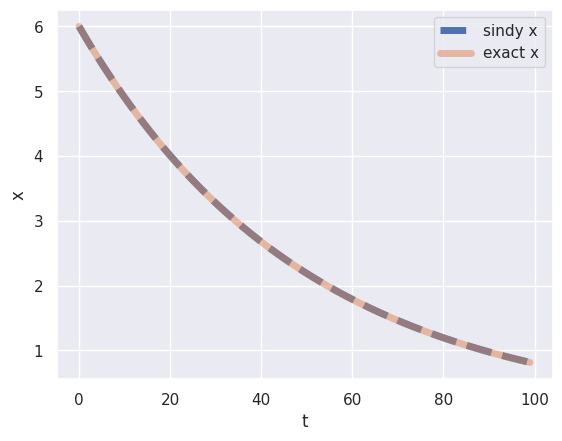

In [11]:
plt.plot(sol[:,0],"--",label = "sindy x",linewidth = 5)
plt.plot(x_test,label = "exact x",alpha = 0.5,linewidth = 5)
plt.xlabel("t")
plt.ylabel("x")
plt.legend()
plt.savefig("x.jpg")

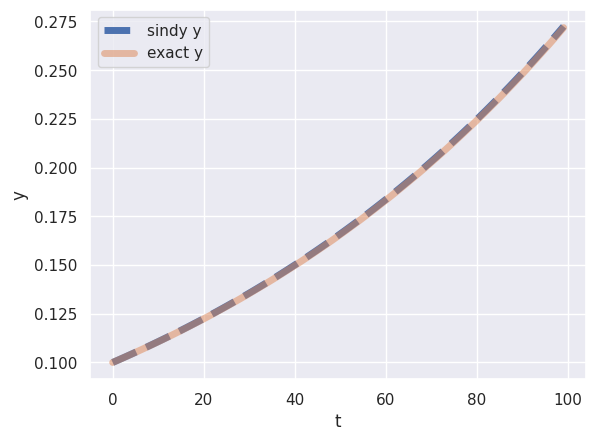

In [12]:
plt.plot(sol[:,1],"--",label = "sindy y",linewidth = 5)
plt.plot(y_test,label = "exact y",alpha = 0.5,linewidth = 5)
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.savefig("y.jpg")

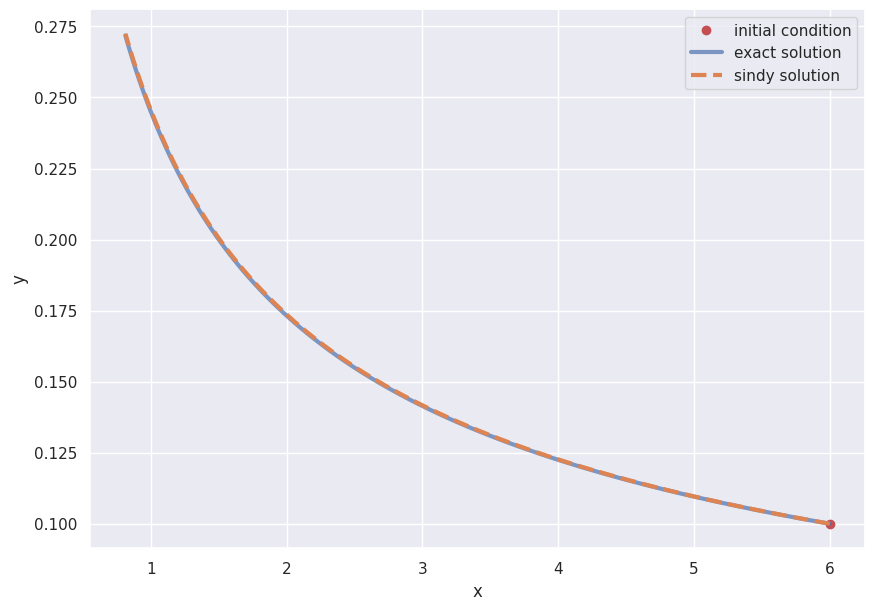

In [13]:
plt.figure(figsize = (10,7))
plt.plot(x0,y0,"ro",label = "initial condition")
plt.plot(x_test,y_test,label = "exact solution",linewidth = 3,alpha = 0.7)
plt.plot(sol[:,0],sol[:,1],"--",label = "sindy solution",linewidth = 3)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.savefig("trajec.jpg")

## Lorentz System

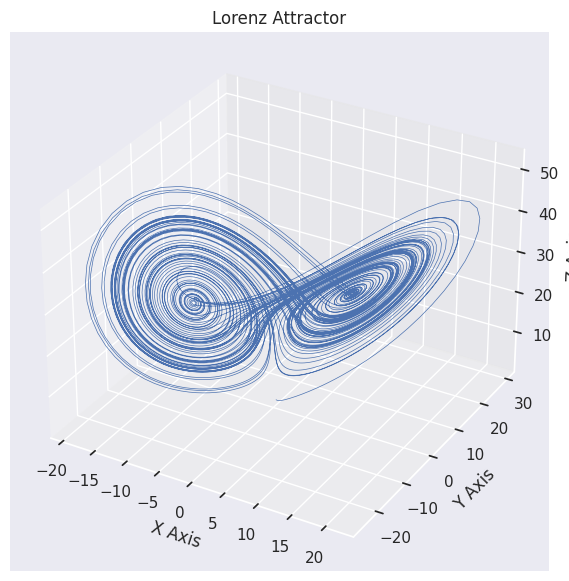

In [14]:
#Generating the Data
def lorenz(x, y, z, s=10, r=28, b=2.667):
    """
    Given:
       x, y, z: a point of interest in three dimensional space
       s, r, b: parameters defining the lorenz attractor
    Returns:
       x_dot, y_dot, z_dot: values of the lorenz attractor's partial
           derivatives at the point x, y, z
    """
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return x_dot, y_dot, z_dot


dt = 0.01
num_steps = 10000

# Need one more for the initial values
xs = np.empty(num_steps + 1)
ys = np.empty(num_steps + 1)
zs = np.empty(num_steps + 1)
# Set initial values
xs[0], ys[0], zs[0] = (0., 1., 1.05)

# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    x_dot, y_dot, z_dot = lorenz(xs[i], ys[i], zs[i])
    xs[i + 1] = xs[i] + (x_dot * dt)
    ys[i + 1] = ys[i] + (y_dot * dt)
    zs[i + 1] = zs[i] + (z_dot * dt)

ax = plt.figure(figsize=(10,7)).add_subplot(projection='3d')

ax.plot(xs, ys, zs, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

In [15]:
X = np.stack((xs,ys,zs),axis = 1)
model_order = 1
poly_order = 3
t = np.linspace(0,dt*num_steps,num_steps+1)
sind_obj = Sindy(X,t,poly_order,model_order,False,False)
gradients = sind_obj.grads
dX = gradients[1]
lib = sind_obj.library(X)
ksi = sind_obj.fit(dX,lib)

In [16]:
x0 = 0
y0 = 1
z0 = 1.05
init_condition = np.array([x0,y0,z0])
sol = simulate1(init_condition,t,ksi,sind_obj.library,"odeint")

In [17]:
fig = make_subplots(rows=1, cols=2,
                    specs=[[{'is_3d': True}, {'is_3d': True}]],
                    subplot_titles=['True attractor', 'Attractor given by SINDy'],
                    )

fig.add_trace(go.Scatter3d(x=xs, y=ys, z=zs,marker=dict(
            color=px.colors.qualitative.D3,
            size=[0, 0, 0],
            sizemode='diameter'
        )), 1, 1)
fig.add_trace(go.Scatter3d(x=sol[:,0], y=sol[:,1], z=sol[:,2],marker=dict(
            color=px.colors.qualitative.D3,
            size=[0, 0, 0],
            sizemode='diameter'
        )), 1, 2)
fig.update_layout(title_text="Example: Lorenz attractor")
fig.write_html("lorenz.html")
fig.show()


In [83]:
print("Coefficient vector = \n",ksi)

Coefficient vector = 
 [[-11.80542157  25.24885554  -0.1240294 ]
 [ 10.47311161   0.2419236    0.        ]
 [  0.           0.          -2.81508271]
 [  0.           0.           0.15539484]
 [  0.           0.           0.89744871]
 [  0.          -0.94465732   0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
